In [1]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import time
import re

# Tic Toc Toe environment

Our 1st game is the famous Tic Toc Toe. You can read about the game and its rules here: https://en.wikipedia.org/wiki/Tic-tac-toe

We implemented the game as an environment in the style of games in the [Python GYM library](https://gym.openai.com/). The commented source code is available in the file "tic_env.py". Here, we give a brief introduction to the environment and how it can be used.

### Initialization and attributes

You can initialize the environment / game as following:

In [2]:
env = TictactoeEnv()

Which then has the following attributes with the corresponding initial values:

In [3]:
env.__dict__

{'grid': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'end': False,
 'winner': None,
 'player2value': {'X': 1, 'O': -1},
 'num_step': 0,
 'current_player': 'X'}

The game is played by two players: player 'X' and player 'O'. The attribute 'current_player' shows whose turn it is. We assume that player 'X' always plays first.

The attribute 'grid' is a 3x3 numpy array and presents the board in the real game and the state $s_t$ in the reinfocement learning language. Each elements can take a value in {0, 1, -1}:
     0 : place unmarked
     1 : place marked with X 
    -1 : place marked with O 
        
The attribute 'end' shows if the game is over or not, and the attribute 'winner' shows the winner of the game: either "X", "O", or None.  

You can use function 'render' to visualize the current position of the board:

In [4]:
env.render()

|- - -|
|- - -|
|- - -|



In [5]:
env.observe()

(array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 False,
 None)

### Test

In [6]:
Turns = np.array(['X','O'])
X_reward = []
O_reward = []
for i in range(1000):
    env.reset()
    grid, _, __ = env.observe()
    player_X = OptimalPlayer(epsilon=0., player='X')
    player_O = OptimalPlayer(epsilon=1., player='O')
    for j in range(9):
        if env.current_player == player_X.player:
            move = player_X.act(grid)
        else:
            move = player_O.act(grid)

        grid, end, winner = env.step(move, print_grid=False)

        if end:
            X_reward.append(env.reward(player='X'))
            O_reward.append(env.reward(player='O'))
            env.reset()
            break
print('Reward X = ' +  str(sum(X_reward)))
print('Reward O = ' +  str(sum(O_reward)))

Reward X = 970
Reward O = -970


# Q-Learning

### 2.1

In [7]:
# create the dictionary of q values based on the grid of tic tac toe
Q_table = {str(np.zeros((3,3))) : np.zeros(9)}
Q_table

{'[[0. 0. 0.]\n [0. 0. 0.]\n [0. 0. 0.]]': array([0., 0., 0., 0., 0., 0., 0., 0., 0.])}

In [8]:
def Q_actions(s):
    # s is a np grid
    if(Q_table.get(str(s),'a') == 'a'):
        Q_table[str(s)] = np.where(s.flatten() == 0, s.flatten(), np.nan)
    return Q_table[str(s)]

In [9]:
# demonstrate that the Q_table gets updated with zeroes and nan when it encounters new position
env.reset()
env.step(0)
Q_actions(env.grid)
Q_table

{'[[0. 0. 0.]\n [0. 0. 0.]\n [0. 0. 0.]]': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 '[[1. 0. 0.]\n [0. 0. 0.]\n [0. 0. 0.]]': array([nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

In [10]:
rng = np.random.default_rng(358)
def epsilon_action(q_vals, eps):
    if (rng.random() < eps):
        #random move
        #gets random non-nan index
        return rng.choice([x[0] for x in enumerate(q_vals) if not np.isnan(x[1])])
    else:
        #first best move
        return np.nanargmax(q_vals)

In [11]:
step_size = 0.05
discount = 0.99
epsilon = 0.3
Q_table = {}
Turns = np.array(['X','O'])

In [12]:
opt_reward = []
learn_reward = []

for i in range(250000):
    moves = []
    
    env.reset()
    grid, _, __ = env.observe()
    player_opt = OptimalPlayer(epsilon=0.5, player=Turns[i%2])
    for j in range(9):
        if env.current_player == player_opt.player:
            move = player_opt.act(grid)
        else:
            # get the q values
            q_vals = Q_actions(env.grid)
            # choose a move
            move = epsilon_action(q_vals, epsilon)
            
            #add position and move to array
            moves.append((np.copy(env.grid), move))
            
            # get move in 2d format
            move = (move//3, move%3)
            
        grid, end, winner = env.step(move)
        
        # update the Q-values, this has to be done after opt moves or when the game ends
        if (env.current_player != player_opt.player) | end:
            # get the current reward
            reward = env.reward(player=Turns[(i+1)%2])
            num_moves = len(moves)
            if num_moves >= 2:
                position = moves[num_moves - 2][0]
                action = moves[num_moves - 2][1]
                Q_next_max = np.nanmax(Q_actions(moves[num_moves - 1][0]))
                # update the Q-value
                Q_table[str(position)][action] += step_size * (reward + discount * Q_next_max - Q_table[str(position)][action])
        
        if end:
            # add rewards to arrays
            opt_reward.append(env.reward(player=Turns[i%2]))
            learn_reward.append(env.reward(player=Turns[(i+1)%2]))
            env.reset()
            break
print('Reward opt = ' +  str(sum(opt_reward)))
print('Reward learn = ' +  str(sum(learn_reward)))

Reward opt = 27915
Reward learn = -27915


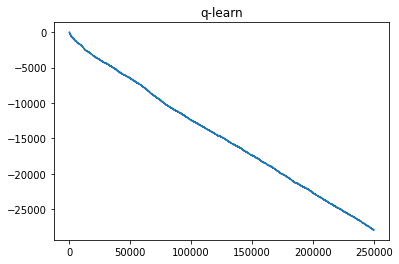

In [13]:
plt.plot(np.cumsum(learn_reward))
plt.title('q-learn')
plt.show()

Chose 0.3 as it should perform better than 0.5 if it gets good (this should be seen in the end), and at the same time it's not too low so it should explore enough.

**Question 1:**

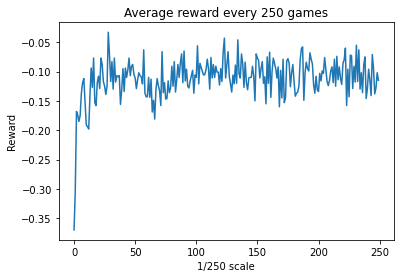

In [14]:
learn250 = np.split(np.asarray(learn_reward), 250)
averages = np.mean(learn250, axis=1)

plt.plot(averages)
plt.title('Average reward every 250 games')
plt.ylabel('Reward')
plt.xlabel('1/250 scale')
plt.show()

Yes there clearly is an upward trend. Could be reflected with stat analysis.

In [15]:
save_q = Q_table

**Question 2 and 3:**

In [16]:
def eps(n, n_star, e_min, e_max):
    return max(e_min, e_max * (1 - (n/n_star)))

In [17]:
def M(e):
    learner_rewards = []
    for i in range(500):
        env.reset()
        grid, _, __ = env.observe()
        player_opt = OptimalPlayer(epsilon=e, player=Turns[i%2])
        for j in range(9):
            if env.current_player == player_opt.player:
                move = player_opt.act(grid)
            else:
                # get the q values
                q_vals = Q_actions(grid)
                # using epsilon 0
                move = epsilon_action(q_vals, 0)
                # get move in 2d format
                move = (move//3, move%3)

            grid, end, winner = env.step(move)

            if end:
                # add rewards to arrays
                learner_rewards.append(env.reward(player=Turns[(i+1)%2]))
                break
                env.reset()
    return (np.count_nonzero(np.asarray(learner_rewards) == 1) - np.count_nonzero(np.asarray(learner_rewards) == -1)) / 500

In [18]:
n_star = [*range(1, 20000, 3500)]
n_star.append(20000)
e_min = 0.1
e_max = 0.8

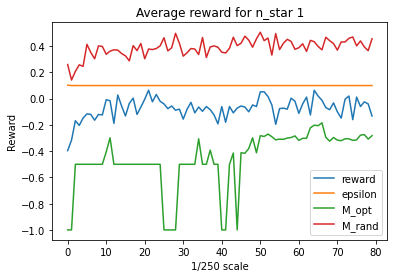

time at 0 363.6579248905182


In [ ]:
for y in range(len(n_star)):
    before = time.time()
    
    # reset q-values between
    Q_table = {} 
    learn_reward = []
    # array for epsilon values to plot
    eps_vals = [] 
    # arrays for M values
    M_opt = []
    M_rand = []
    for i in range(20000):
        moves = []

        env.reset()
        grid, _, __ = env.observe()
        player_opt = OptimalPlayer(epsilon=0.5, player=Turns[i%2])
        for j in range(9):
            if env.current_player == player_opt.player:
                move = player_opt.act(grid)
            else:
                # get the q values
                q_vals = Q_actions(env.grid)
                # using new decreasing epsilon
                epsilon = eps(i, n_star[y], e_min, e_max)
                move = epsilon_action(q_vals, epsilon)
                # add position and move to array
                moves.append((np.copy(env.grid), move))
                # get move in 2d format
                move = (move//3, move%3)

            grid, end, winner = env.step(move)

            # update the Q-values, this has to be done after opt moves or when the game ends
            if (env.current_player != player_opt.player) | end:
                # get the current reward
                reward = env.reward(player=Turns[(i+1)%2])
                num_moves = len(moves)
                if num_moves >= 2:
                    position = moves[num_moves - 2][0]
                    action = moves[num_moves - 2][1]
                    Q_next_max = np.nanmax(Q_actions(moves[num_moves - 1][0]))
                    # update all the Q-values up to the current move
                    Q_table[str(position)][action] += step_size * (reward + discount * Q_next_max - Q_table[str(position)][action])
            if end:
                # add rewards to arrays
                learn_reward.append(env.reward(player=Turns[(i+1)%2]))
                # add to array for plotting
                eps_vals.append(epsilon) 
                env.reset()
                break
        # get the M values every 250th game
        if (i%250) == 0:
            M_opt.append(M(0))
            M_rand.append(M(1))
    # the the averages per 250 values
    learn250 = np.split(np.asarray(learn_reward), 80)
    learn_averages = np.mean(learn250, axis=1)
    eps250 = np.split(np.asarray(eps_vals), 80)
    eps_averages = np.mean(eps250, axis=1)

    title = 'Average reward for n_star ' + str(n_star[y])
    plt.plot(learn_averages, label = 'reward')
    plt.plot(eps_averages, label = 'epsilon')
    plt.plot(M_opt, label = 'M_opt')
    plt.plot(M_rand, label = 'M_rand')
    plt.title(title)
    plt.ylabel('Reward')
    plt.xlabel('1/250 scale')
    plt.legend()
    plt.show()
    
    after = time.time()
    print('time at',y,after-before)

**Q2 answer:**

We can see that it uses more time to explore before in the later stages it exploit more.

The effect of n_star seems to be that the explore phase gets extended, but it does not seem to end any higher on avg reward when it reaches 0.1 epsilon.

**Question 3:**

For the winning rate we can see that larger values seem to have more stable learning and end up higher probably as they have explored more early.

### 2.1.2
Good and bad experts

In [ ]:
n_star_opt = 12000
e_min = 0.1
e_max = 0.8
e_opt = [x / 10.0 for x in range(0, 10, 2)]

In [ ]:
for y in range(len(e_opt)):
    before = time.time()
    
    # reset q-values between
    Q_table = {} 
    learn_reward = []
    # array for epsilon values to plot
    eps_vals = [] 
    # arrays for M values
    M_opt = []
    M_rand = []
    for i in range(20000):
        moves = []

        env.reset()
        grid, _, __ = env.observe()
        player_opt = OptimalPlayer(epsilon=e_opt[y], player=Turns[i%2])
        for j in range(9):
            if env.current_player == player_opt.player:
                move = player_opt.act(grid)
            else:
                # get the q values
                q_vals = Q_actions(env.grid)
                # using optimal n_star decreasing epsilon
                epsilon = eps(i, n_star_opt, e_min, e_max)
                move = epsilon_action(q_vals, epsilon)
                # add position and move to array
                moves.append((np.copy(env.grid), move))
                # get move in 2d format
                move = (move//3, move%3)

            grid, end, winner = env.step(move)

            # update the Q-values, this has to be done after opt moves or when the game ends
            if (env.current_player != player_opt.player) | end:
                # get the current reward
                reward = env.reward(player=Turns[(i+1)%2])
                num_moves = len(moves)
                if num_moves >= 2:
                    position = moves[num_moves - 2][0]
                    action = moves[num_moves - 2][1]
                    Q_next_max = np.nanmax(Q_actions(moves[num_moves - 1][0]))
                    # update all the Q-values up to the current move
                    Q_table[str(position)][action] += step_size * (reward + discount * Q_next_max - Q_table[str(position)][action])
            if end:
                # add rewards to arrays
                learn_reward.append(env.reward(player=Turns[(i+1)%2]))
                # add to array for plotting
                eps_vals.append(epsilon) 
                env.reset()
                break
        # get the M values every 250th game
        if (i%250) == 0:
            M_opt.append(M(0))
            M_rand.append(M(1))
    # the the averages per 250 values
    learn250 = np.split(np.asarray(learn_reward), 80)
    learn_averages = np.mean(learn250, axis=1)
    eps250 = np.split(np.asarray(eps_vals), 80)
    eps_averages = np.mean(eps250, axis=1)

    title = 'Average reward for e_opt ' + str(e_opt[y])
    plt.plot(learn_averages, label = 'reward')
    plt.plot(eps_averages, label = 'epsilon')
    plt.plot(M_opt, label = 'M_opt')
    plt.plot(M_rand, label = 'M_rand')
    plt.title(title)
    plt.ylabel('Reward')
    plt.xlabel('1/250 scale')
    plt.legend()
    plt.show()
    
    after = time.time()
    print('time at',y,after-before)

There are some interesting straight lines at 0.5 for M_opt. This could be that it loses every game it does not start and draws every game it starts, or it could be due to a bug...

**Question 4:**

We observe that lower epsilon corresponds to: 
and higher epsilon corresponds to:

This can be explained by 



**Question 5:**

The highest M_opt and M_rand achieved are:

M_opt of .... for epsilon X at time :....

M_rand of .... for epsilon X at time :....

**Question 6:**

Optimal strategy against Opt(0) and optimal strategy against Opt(1) does not have to be the same..
The optimal strat described as picking middle, then corner then block etc. would good vs optimal player,

but perhaps vs random player it could be advantageous to not block win if the chance is small that it picks by random and you can win on text turn.



## 2.2

This is selfplay with fixed epsilon between 0-1.

In [ ]:
e_learn = [x / 10.0 for x in range(0, 10, 2)]

In [ ]:
for y in range(len(e_learn)):
    before = time.time()
    
    # reset q-values between
    Q_table = {} 
    a_reward = []
    b_reward = []
    # arrays for M values
    M_opt = []
    M_rand = []
    for i in range(20000):
        a_moves = []
        b_moves = []

        env.reset()
        grid, _, __ = env.observe()
        for j in range(9):
            if i%2 == 0:
                # get the q values
                q_vals = Q_actions(env.grid)
                # using epsilon from fixed values
                epsilon = e_learn[y]
                move = epsilon_action(q_vals, epsilon)
                # add position and move to array
                a_moves.append((np.copy(env.grid), move))
                # get move in 2d format
                move = (move//3, move%3)
            else:
                q_vals = Q_actions(env.grid)
                epsilon = e_learn[y]
                move = epsilon_action(q_vals, epsilon)
                # append to b_moves
                b_moves.append((np.copy(env.grid), move))
                move = (move//3, move%3)

            grid, end, winner = env.step(move)

            # update the Q-values, this has to be done after opt moves or when the game ends
            if (i%2 == 0) | end:
                # get the current reward
                reward = env.reward(player='X')
                num_moves = len(a_moves)
                if num_moves >= 2:
                    position = a_moves[num_moves - 2][0]
                    action = a_moves[num_moves - 2][1]
                    Q_next_max = np.nanmax(Q_actions(a_moves[num_moves - 1][0]))
                    # update all the Q-values up to the current move
                    Q_table[str(position)][action] += step_size * (reward + discount * Q_next_max - Q_table[str(position)][action])
            if ((i + 1) % 2 == 0) | end:
                reward = env.reward(player='O')
                num_moves = len(b_moves)
                if num_moves >= 2:
                    position = b_moves[num_moves - 2][0]
                    action = b_moves[num_moves - 2][1]
                    Q_next_max = np.nanmax(Q_actions(b_moves[num_moves - 1][0]))
                    # update all the Q-values up to the current move
                    Q_table[str(position)][action] += step_size * (reward + discount * Q_next_max - Q_table[str(position)][action])
                    
            if end:
                # add rewards to arrays
                a_reward.append(env.reward(player='X'))
                b_reward.append(env.reward(player='O'))
                env.reset()
                break
        # get the M values every 250th game
        if (i%250) == 0:
            M_opt.append(M(0))
            M_rand.append(M(1))
    # the the averages per 250 values
    a250 = np.split(np.asarray(a_reward), 80)
    a_averages = np.mean(a250, axis=1)
    b250 = np.split(np.asarray(b_reward), 80)
    b_averages = np.mean(b250, axis=1)
    eps250 = np.split(np.asarray(eps_vals), 80)
    eps_averages = np.mean(eps250, axis=1)

    title = 'Average reward for selfplay with eps ' + str(e_learn[y])
    plt.plot(a_averages, label = 'X')
    plt.plot(b_averages, label = 'O')
    plt.plot(M_opt, label = 'M_opt')
    plt.plot(M_rand, label = 'M_rand')
    plt.title(title)
    plt.ylabel('Reward')
    plt.xlabel('1/250 scale')
    plt.legend()
    plt.show()
    
    after = time.time()
    print('time at',y,after-before)

**Question 7:**
It seems the agent improves with selfplay tabular Q-learning, but it does not reach a high level.

The effect of epsilon seems to be:
At 0 it gets stuck and does not improve.

Above 0 it achieves some success, it seems 0.2 is the best epsilon from 0-0.4


**With varying Epsilon:** according to n_star

In [ ]:
n_star = [*range(1, 20000, 3500)]
n_star.append(20000)
e_min = 0.1
e_max = 0.8

In [ ]:
for y in range(len(n_star)):
    before = time.time()
    
    # reset q-values between
    Q_table = {} 
    a_reward = []
    b_reward = []
    # array for epsilon values to plot
    eps_vals = [] 
    # arrays for M values
    M_opt = []
    M_rand = []
    for i in range(20000):
        a_moves = []
        b_moves = []

        env.reset()
        grid, _, __ = env.observe()
        for j in range(9):
            if i%2 == 0:
                # get the q values
                q_vals = Q_actions(env.grid)
                # using optimal n_star decreasing epsilon
                epsilon = eps(i, n_star[y], e_min, e_max)
                move = epsilon_action(q_vals, epsilon)
                # add position and move to array
                a_moves.append((np.copy(env.grid), move))
                # get move in 2d format
                move = (move//3, move%3)
            else:
                q_vals = Q_actions(env.grid)
                epsilon = eps(i, n_star[y], e_min, e_max)
                move = epsilon_action(q_vals, epsilon)
                # append to b_moves
                b_moves.append((np.copy(env.grid), move))
                move = (move//3, move%3)

            grid, end, winner = env.step(move)

            # update the Q-values, this has to be done after opt moves or when the game ends
            if (i%2 == 0) | end:
                # get the current reward
                reward = env.reward(player='X')
                num_moves = len(a_moves)
                if num_moves >= 2:
                    position = a_moves[num_moves - 2][0]
                    action = a_moves[num_moves - 2][1]
                    Q_next_max = np.nanmax(Q_actions(a_moves[num_moves - 1][0]))
                    # update all the Q-values up to the current move
                    Q_table[str(position)][action] += step_size * (reward + discount * Q_next_max - Q_table[str(position)][action])
            if ((i + 1) % 2 == 0) | end:
                reward = env.reward(player='O')
                num_moves = len(b_moves)
                if num_moves >= 2:
                    position = b_moves[num_moves - 2][0]
                    action = b_moves[num_moves - 2][1]
                    Q_next_max = np.nanmax(Q_actions(b_moves[num_moves - 1][0]))
                    # update all the Q-values up to the current move
                    Q_table[str(position)][action] += step_size * (reward + discount * Q_next_max - Q_table[str(position)][action])
                    
            if end:
                # add rewards to arrays
                a_reward.append(env.reward(player='X'))
                b_reward.append(env.reward(player='O'))
                # add to array for plotting
                eps_vals.append(epsilon) 
                env.reset()
                break
        # get the M values every 250th game
        if (i%250) == 0:
            M_opt.append(M(0))
            M_rand.append(M(1))
    # the the averages per 250 values
    a250 = np.split(np.asarray(a_reward), 80)
    a_averages = np.mean(a250, axis=1)
    b250 = np.split(np.asarray(b_reward), 80)
    b_averages = np.mean(b250, axis=1)
    eps250 = np.split(np.asarray(eps_vals), 80)
    eps_averages = np.mean(eps250, axis=1)

    title = 'Average reward for selfplay with n_star of ' + str(n_star[y])
    plt.plot(a_averages, label = 'X')
    plt.plot(b_averages, label = 'O')
    plt.plot(eps_averages, label = 'epsilon')
    plt.plot(M_opt, label = 'M_opt')
    plt.plot(M_rand, label = 'M_rand')
    plt.title(title)
    plt.ylabel('Reward')
    plt.xlabel('1/250 scale')
    plt.legend()
    plt.show()
    
    after = time.time()
    print('time at',y,after-before)

**Question 8:**
Decreasing epsilon seems to have a *** impact on learning rate.

The effect of n_star seems to be:



**Question 9:**
The highest values of M_opt and M_rand is ***


**Question 10:**
Heat map for Q-values for 3 different states S.


In [ ]:
symbol_map = {'-1' : 'O', '1': 'X'}
def heatmap(pos):
    arr = Q_table[pos].reshape((3,3))
    
    fig, ax = plt.subplots()
    im = ax.imshow(arr)
    # Loop over data dimensions and create text annotations.
    for i in range(3):
        for j in range(3):
            if np.isnan(arr[i, j]):
                symbol = symbol_map[re.findall("-?\d", pos)[(3*i)+j]]
                text = ax.text(j, i, symbol,
                           ha="center", va="center")
            else:
                text = ax.text(j, i, format(arr[i, j], ".3f"),
                           ha="center", va="center")
    ax.set_title("Heatmap of Q-values")
    fig.tight_layout()
    plt.show()

In [ ]:
# 1 state for the beginning
heatmap('[[0. 0. 0.]\n [0. 0. 0.]\n [0. 0. 0.]]')
# 1 state for blocking 3 in a row
heatmap('[[-1.  1. -1.]\n [ 1.  0.  1.]\n [ 0.  0.  0.]]')
# 1 state for getting 3 in a row
heatmap('[[-1. -1.  0.]\n [ 0.  1.  1.]\n [ 0.  0.  1.]]')

Makes sense?

**For 1:**
No..

**For 2:**
No, middle should be way higher value. As in next turn it will have winning move any way

**For 3:**
No... It seems to have missed the corner. Values are bad.

Did the agent learn the game well?
Not so well,

# 3 Deep Q-Learning

Implement it like in [https://keras.io/examples/rl/deep_q_network_breakout/]

In [ ]:
example_grid = np.array([[1,-1,0],[0,1,-1],[-1,1,0]])
example_grid

In [ ]:
def grid_to_tensor(grid):
    x = (grid == 1).astype(int)
    o = (grid == -1).astype(int)
    return np.dstack([x,o])

In [ ]:
# demonstrate that it transforms to tensor the right way
print(grid_to_tensor(example_grid))
print(grid_to_tensor(example_grid).shape)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Configuration paramaters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 0.2 # the fixed epsilon parameter for question 11
batch_size = 64  # Size of batch taken from replay buffer
update_step = 500 #update at every 500 step
buffer_size = 10000

num_actions = 9

max_memory_length = 10000

rng = np.random.default_rng(499)

In [ ]:
def create_q_model():
    inputs = layers.Input(shape=(3, 3, 2))
    layer1 = layers.Dense(128, activation="relu")(inputs)
    layer2 = layers.Dense(128, activation="relu")(layer1)
    layer3 = layers.Flatten()(layer2)
    action = layers.Dense(9, activation="linear")(layer3)

    return keras.Model(inputs=inputs, outputs=action)

#using adam optimizer with learning rate 5e-4
optimizer = keras.optimizers.Adam(learning_rate=5e-4)

# Using huber loss for stability
loss_function = keras.losses.Huber()

model = create_q_model()
model_target = create_q_model()

In [ ]:
# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0

for i in range(1000):  # run 20000 times
    env.reset()
    episode_reward = 0

    player_opt = OptimalPlayer(epsilon=0.5, player=Turns[i%2])
    for j in range(9):
        state = np.copy(env.grid)
        done = False
        reward = 0
        
        if env.current_player == player_opt.player:
            action_2d = player_opt.act(grid)
        else:
            # Use epsilon-greedy for exploration
            if epsilon > rng.random():
                # Take random action
                action = rng.choice(num_actions)
                action_2d = (action//3, action%3)
            else:
                # Predict action Q-values
                # From environment state
                state_tensor = grid_to_tensor(env.grid)
                state_tensor = tf.expand_dims(state_tensor, 0)
                action_probs = model(state_tensor, training=False)
                # Take best action
                action = tf.argmax(action_probs[0]).numpy()
                action_2d = (action//3, action%3)
        
        # if taking illegal move
        if state[action_2d[0]][action_2d[1]] != 0:
            reward = -1
            done = True #finish game
            episode_reward += reward
            # Save actions and states in replay buffer
            action_history.append(action)
            state_history.append(state)
            state_next_history.append(state_next)
            done_history.append(done)
            rewards_history.append(reward)
            
        if not done:
            state_next, end, winner = env.step(action_2d)
        
        if env.current_player == player_opt.player:
            episode_reward += reward
            # Save actions and states in replay buffer
            action_history.append(action)
            state_history.append(state)
            state_next_history.append(state_next)
            done_history.append(done)
            rewards_history.append(reward)
            state = state_next

        # Update after every game
        if done:
            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            # reshape to 64, 3, 3, 2
            future_rewards = model_target.predict(np.array([grid_to_tensor(x) for x in state_next_sample]))
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}"
            print(template.format(running_reward, episode_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if running_reward > 40:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

In [ ]:
print(action_history)
print(state_history)
print(state_next_history)
print(rewards_history)
print(done_history)
print(episode_reward_history)

In [ ]:
print(np.array([grid_to_tensor(x) for x in state_next_sample]).shape)